In [ ]:
# @title Install packages

# @markdown optional

# !python -m pip uninstall matplotlib
# !pip install matplotlib==3.1.3
# !pip install viziphant

In [ ]:
# @title Load modules
import os, requests
import numpy as np
from time import time
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# @title Set global variables
session = 12
time_window = (1,1.5) # (1,1.5)  # s
num_choices = 2  # 2 or 3
binsize = 2 # ms
accuracy_threshold = 0.6

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
  print("GPU is not enabled in this notebook")

GPU is not enabled in this notebook


In [ ]:
#@title Get  data
# @markdown `data_spiketrains`
# @markdown `data_labels`

### Spiketrain ###
fname = ['steinmetz_st.npz']
# fname.append('steinmetz_wav.npz')
# fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
# url.append("https://osf.io/ugm9v/download")
# url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
data_spiketrains = dat_ST[session]['ss']
print(f'data_spiketrains: {data_spiketrains.shape}')
del dat_ST

### Labels ### 
fname = []
for j in range(1):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
# url.append("https://osf.io/uv3mw/download")
# url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

data_labels = alldat[session]['response']
print(f'data_labels: {data_labels.shape}')
del alldat

# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

data_spiketrains: (983, 300)
data_labels: (300,)


In [ ]:
# @title Preprocessing data

## Cut trials in time window
num_neurons, num_trials = data_spiketrains.shape

# print(data_spiketrains[20,15])
for neuron_id, neuron in enumerate(data_spiketrains):
  for trial, spiketrain in enumerate(neuron):
    spiketrain = spiketrain[time_window[0] <= spiketrain]
    spiketrain = spiketrain[spiketrain < time_window[1]]
    spiketrain -= time_window[0]
    data_spiketrains[neuron_id, trial] = spiketrain
# print(data_spiketrains[20,15])

## remove label 0 trials
if num_choices == 2:
   trial_idx = np.where(data_labels)[0]
   data_spiketrains = data_spiketrains[:, trial_idx]
   data_labels = data_labels[trial_idx]
   data_labels = (data_labels+1)/2
else:
   data_labels = int(data_labels+1)
   
print(f'data_spiketrains: {data_spiketrains.shape}')
print(f'data_labels: {data_labels.shape}')

data_spiketrains: (983, 244)
data_labels: (244,)


In [49]:
# @title Select Units

df = pd.read_csv('/drive/My Drive/Neuromatch-DL-project/results/choice-predict-logit-r2/session'+str(session)+'.csv')

def select_units(df, accuracy_threshold):

  index = df['accuracy'] > accuracy_threshold
  df = df.loc[index]

  return index, df


index, df_select = select_units(df, accuracy_threshold)

print(f"found {len(df_select)} units with threshold {accuracy_threshold}")
print(df_select.head())

data_spiketrains_s = data_spiketrains[index.to_numpy(), :]
print(f'data_spiketrains: {data_spiketrains_s.shape}')

found 41 units with threshold 0.6
     unit area  accuracy
87     87  LGd  0.610656
180   180  LGd  0.618852
248   248  LGd  0.627049
250   250   MB  0.618852
252   252   RN  0.610656
data_spiketrains: (41, 244)


In [ ]:
# @title Simulate data
def simulate_data(encoding="frequency", n_conditions=5, n_trials=100, dur_trial=1.0, dur_bin=0.001, n_cells=50):
  """
    Simulate data like in (Szabó & Barthó, 2020) to test the networks prediction.

    Arguments:
      encoding (str): how the stimulus is encoded. Can be "frequency" (stimulus determines
        firing rate, spatial pattern is random) or "population" (firing rate is constant,
        stimulus determines spatial pattern).
      n_conditions (int): the number of conditions (stimuli, choices etc.) that are encoded.
      trial_dur (float): duration of a single trial in seconds.
      dur_bin (float): duration of a single bin in seconds.
      n_cells (int): number of cells in the simulation (only used if `encoding == "frequency"`).

    Returns:
      (np.ndarray): 4D matrix where the 1st dimension corresponds to condition and the second to
        the number of trials. The last two dimensions form the one-hot encoded matrix of a single
        trial of shape time_bins x cells.
      (np.ndarray): Vector containing the condition identifiers for the data.

    Example:
      import numpy as np
      from matplotlib import pyplot as plt
      data, _ = simulate_data(encoding="population")
      plt.imshow(data[0,:,:])
  """
  bins = np.arange(0, dur_trial, step=dur_bin)
  n_bins = bins.shape[0]
  s = np.linspace(1, n_conditions, n_conditions) # the stimulus identifiers 
  data = np.zeros([n_conditions, n_trials, n_bins])
  for i in range(n_conditions):
    if encoding == "frequency":
        firing_prob = .05*s[i] # probability of an element being non-zero
    else:
      firing_prob = .1
    n_non0 = int(n_bins*firing_prob) # number of non-zero elements in the vector
    for t in range(n_trials):
      if encoding == "population":
        cell_ids = np.random.choice([2*s[i]-1, 2*s[i], 2*s[i]+1], size=n_non0)
      else:
        cell_ids = np.random.randint(1, n_cells, size=n_non0)
      trial_data = np.zeros(n_bins)
      trial_data[0:n_non0] = cell_ids
      np.random.shuffle(trial_data)
      data[i, t, :] = trial_data
  
  # make a one-hot encoded matrix of shape time x cells for each trial
  data = data.astype("int")
  cells = np.unique(data)[1:] # ??
  n_cells= len(cells) # ??
  one_hot_data = np.zeros([n_conditions, n_trials, n_bins, n_cells])
  print(one_hot_data.shape)
  for c in range(n_conditions):
    for t in range(n_trials):
      for b in range(n_bins):
        if data[c, t, b]!=0:
          one_hot_data[c,t,b, data[c, t, b]-1] = 1

  labels = np.repeat(s, data.shape[1])
  features = one_hot_data.reshape(one_hot_data.shape[0]*one_hot_data.shape[1], one_hot_data.shape[2], one_hot_data.shape[3])

  return features, labels

onehot_trials_sim, labels_sim = simulate_data(encoding="frequency", 
                                              n_conditions=num_choices, 
                                              n_trials=50, 
                                              dur_trial=time_window[1]-time_window[0], 
                                              dur_bin=binsize/1000, 
                                              n_cells=data_spiketrains.shape[0])


In [69]:
# @title Helper functions

def create_identity_matrix(session_data, binsize=1):
  num_neurons, num_trials = session_data.shape
  duration = (time_window[1] - time_window[0]) * 1000
  num_bins = int(duration / binsize)  # 2.5s trial duration

  identity_matrix = np.zeros((num_trials, num_bins), dtype=int)

  for trial in range(num_trials):

    bin_list = [[] for i in range(num_bins)]
    for neuron_id, spiketrain in enumerate(session_data[:,trial]):
      spike_bins = (spiketrain * 1000 / binsize).astype(int)
      for bin in spike_bins:
        bin_list[bin].append(neuron_id+1)

    for bin, bin_column in enumerate(bin_list):
      name_array = np.array(bin_column)
      if len(name_array):
        neuron_name = np.random.choice(name_array)
        identity_matrix[trial, bin] = neuron_name

  return identity_matrix


def manyhot_encoding(data_spiketrains, binsize=1):
  num_neurons, num_trials = data_spiketrains.shape
  duration = (time_window[1] - time_window[0]) * 1000
  num_bins = int(duration / binsize)  # 2.5s trial duration

  encoding_matrix = np.zeros((num_trials, num_bins, num_neurons), dtype=int)

  for trial in range(num_trials):
    for neuron_id, spiketrain in enumerate(data_spiketrains[:,trial]):
      spike_bins = (spiketrain * 1000 / binsize).astype(int)
      encoding_matrix[trial, spike_bins, neuron_id] = 1

  return encoding_matrix


def onehot_encoding(data_spiketrains, binsize=1):
  num_neurons, num_trials = data_spiketrains.shape
  identity_matrix = create_identity_matrix(data_spiketrains, binsize)
  _, num_bins = identity_matrix.shape
  print(f'bins: {num_bins} \t neurons: {num_neurons}')

  onehot_encoder = OneHotEncoder(categories=[np.arange(0,num_neurons+1)],
                                 sparse=False) 

  X = identity_matrix[0, :].reshape(-1,1) # first trial
  enc = onehot_encoder.fit(X) # n_samples x n_features

  onehot_trials = np.empty((num_trials, num_bins, num_neurons+1))

  for trial in range(num_trials):
    trial_row = identity_matrix[trial, :].reshape(-1,1)
    onehot_trial = enc.transform(trial_row)
    onehot_trials[trial] = onehot_trial
  
  return onehot_trials[:, :, 1:] # remove 'no neuron fires' row



def traintest(features, labels, model, 
              loss_fun=None, optimizer=None, device='cuda',
              n_epochs=100, test_size=0.2, lr=0.001, batch_size=1):

  """Training function
  Args:
    features (torch.Tensor): features (input) with shape torch.Size([n_samples, 1])
    labels (torch.Tensor): labels (targets) with shape torch.Size([n_samples, 1])
    model (torch nn.Module): the neural network
    loss_fun (function): loss function
    optimizer(function): optimizer
    n_epochs (int): number of training iterations
  Returns:
    list: record (evolution) of training losses
  """
  if loss_fun is None:
    loss_fun = nn.CrossEntropyLoss().to(device)
  if optimizer is None:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  if type(labels) == np.ndarray:
    labels = torch.LongTensor(labels)
  if type(features) == np.ndarray:
    features = torch.tensor(features)

  output_size = len(np.unique(labels))
  
  loss_record_train = []  # keeping records of loss
  loss_record_test = []  # keeping records of loss
  num_trials = features.shape[0]
  train_trials, test_trials, train_labels, test_labels = train_test_split(features, labels, test_size=test_size)

  # test_trials_t_perturbed = data_perturbation_t(test_trials, rng, n_permutation)
  # test_trials_t_perturbed = torch.tensor(test_trials_t_perturbed)

  test_trials_tc_perturbed = data_perturbation_tc(test_trials, rng, n_permutation)
  test_trials_tc_perturbed = torch.tensor(test_trials_tc_perturbed)

  
  train_trials, test_trials = train_trials.to(device), test_trials_tc_perturbed.to(device)
  train_labels, test_labels = train_labels.to(device), test_labels.to(device)
  model = model.to(device)

  for i in range(n_epochs):
    optimizer.zero_grad()  # set gradients to 0
    train_predictions = torch.empty(((len(train_trials)), output_size), dtype=torch.float, device=device)
    test_predictions = torch.empty(((len(test_trials)), output_size), dtype=torch.float, device=device)

    # # training
    # for trial, train_trial in enumerate(train_trials):
    #   trial_prediction = model(train_trial)  # Compute model prediction (output)
    #   train_predictions[trial, :] = trial_prediction

    for batch in range(0, len(train_trials), batch_size):
      input = train_trials[batch:batch+batch_size]
      batch_predictions = model(input)
      train_predictions[batch:batch+batch_size, :] = batch_predictions

    train_loss = loss_fun(train_predictions, train_labels)  # Compute the loss
    train_loss.backward()  # Compute gradients (backward pass)
    train_loss.detach()
    optimizer.step()  # update parameters (optimizer takes a step)
    loss_record_train.append(train_loss.item())

    # # testing
    for trial, test_trial in enumerate(test_trials):
      test_input = test_trial[np.newaxis, :, :]
      trial_prediction = model(test_input)  # Compute model prediction (output)
      test_predictions[trial, :] = trial_prediction

    test_loss = loss_fun(test_predictions, test_labels)  # Compute the loss
    loss_record_test.append(test_loss.item())
    
  return loss_record_train, loss_record_test

In [ ]:
# @title Alternative code snippets (not used)

# from elephant.conversion import BinnedSpikeTrain
# import neo
# import quantities as pq


# def create_spiketrain_list(data, session, trial, duration=2.5*pq.s):
#   ## transform numpy spike time seris into neo.SpikeTrain objects
#   session_data = data[session]['ss']
#   num_neurons = session_data.shape[0]
#   sts = [neo.SpikeTrain(session_data[neuron,trial]*pq.s,
#                       t_start = 0*pq.s,
#                       t_stop = duration,
#                       trial = trial,
#                       session = session)
#         for neuron in range(num_neurons)]
#   return sts


# def binned_matrix_to_sentence(binned_matrix):
#   if type(binned_matrix) == BinnedSpikeTrain:
#     binned_matrix = binned_matrix.to_array()
  
#   sentence = np.empty(binned_matrix.shape[1])
  
#   ## fill sentence vector with neuron identities
#   for i, col in enumerate(binned_matrix.T):
#     indices = np.where(col)[0]
#     if len(indices) == 0:
#       sentence[i] = 0
#     elif len(indices) == 1:
#       sentence[i] = indices[0] + 1
#     elif len(indices) > 1:
#       sentence[i] = np.random.choice(indices)
#     else:
#       raise(ValueError, 'sth went wrong!!')
#   return sentence  


# def create_identity_matrix(data, session, trial_duration=2.5*pq.s, binsize=1*pq.ms):
#   session_data = data[session]['ss']
#   num_trials = session_data.shape[1]
#   num_neurons = session_data.shape[0]
#   num_bins = int((trial_duration / binsize).simplified.magnitude)
#   print(f'number of neurons = {num_neurons}\t number of trials = {num_trials}')

#   identity_matrix = np.zeros((num_trials, num_bins))

#   for trial in range(num_trials):
#     spiketrain_list = create_spiketrain_list(data, session, trial, trial_duration)
#     binned_spiketrains = BinnedSpikeTrain(spiketrain_list, bin_size=binsize)
#     sentence_vector = binned_matrix_to_sentence(binned_spiketrains)
#     identity_matrix[trial] = sentence_vector

#   return identity_matrix


# # one hot encoder example
# from sklearn.preprocessing import OneHotEncoder

# num_neurons = 4   # = categories-1 (0 is an extra category)

# onehot_encoder = OneHotEncoder(categories=[np.arange(0,num_neurons+1)],
#                                sparse=False) 

# X = np.array([1,2,3,2,1]).reshape(-1,1)  # example data to define the encoder
# print(X.shape) # has single feature (neuron name)
# enc = onehot_encoder.fit(X) # n_samples x n_features

# print(enc.categories_)
# print(enc.get_feature_names())
# X1 = np.array([0,2,3,4,1]).reshape(-1,1)
# print(enc.transform(X1))



### Alternative 2: Embedding function
# input = torch.LongTensor(onehot_trial)
# embedding = nn.Embedding(self.cell_size, self.embed_size)
# embed_out = embedding(input)
# embed_out = embed_out.select(1,2)

### Alternative 3: Matrix multiplication
## equivalent but does not learn!
# input = torch.tensor(onehot_trial).float()
# embedding_matrix = torch.randn((self.cell_size, self.embed_size), 
#                                requires_grad=True)
# embed_out = input @ embedding_matrix

In [ ]:
# @title Model defintion

class Embedder(nn.Module):
  def __init__(self, bins_size, cell_size, embed_size, 
               hidden_size, output_size, attention_size, verbose=False):  
    super(Embedder, self).__init__()
    # params
    self.bins_size = bins_size
    self.cell_size = cell_size
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.reduction_size = 1000
    self.verbose = verbose
    # layers
    self.fc_embed = nn.Linear(cell_size, embed_size)
    self.gru = nn.GRU(embed_size, hidden_size, 
                      num_layers=1, batch_first=True)
    self.attn = nn.Linear(hidden_size, hidden_size)      
    self.attn_combine = nn.Linear(hidden_size, attention_size)  
    self.fc1 = nn.Linear(hidden_size*attention_size, self.reduction_size)
    self.fc2 = nn.Linear(self.reduction_size, output_size)

  def attention_net(self, input):
    attention_input = self.attn(input)
    attn_weight_matrix = self.attn_combine(torch.tanh(attention_input))     #compute linear combination of all GRU hidden vectors, takes the whole GRU hidden states as input (ie. stored in output), and outputs a vector of weights 
    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)
    return attn_weight_matrix

  def forward(self, input):  
    #### Neuron Embedding
    input = torch.tensor(input).float()
    embed_out = self.fc_embed(input)
    if self.verbose: print(f'embed out:{embed_out.shape}')

    #### Spatial Embedding
    gru_out,_ = self.gru(embed_out)
    # gru_out = gru_out.permute(0,2,1)
    if self.verbose: print(f'gru out:{gru_out.shape}')

    #### Attention Mechanism
    attn_weights = self.attention_net(gru_out)
    attention_out = torch.bmm(attn_weights, gru_out)
    if self.verbose: print(f'attention out:{attention_out.shape}')

    #### Transform to the correct output shape
    attention_out = torch.flatten(attention_out, start_dim=1)

    fc1_out = self.fc1(attention_out)
    # fc1_out = fc1_out.reshape(fc1_out.shape[0], self.hidden_size)
    if self.verbose: print(f'fc1 out:{fc1_out.shape}')

    fc1_out = torch.sigmoid(fc1_out)

    fc2_out = self.fc2(fc1_out)
    # fc2_out = fc2_out.reshape(fc2_out.shape[0], self.output_size)
    if self.verbose: print(f'fc2 out:{fc2_out.shape}')
    
    probs = F.log_softmax(fc2_out, dim=1)
    if self.verbose: print(f'decision:{probs.shape}')

    return probs

In [50]:
# @title Encode data into matrix

num_test_trials = len(data_labels)

onehot_trials = onehot_encoding(data_spiketrains[:, :num_test_trials], 
                                binsize=binsize)
print(onehot_trials.shape)

manyhot_trials = manyhot_encoding(data_spiketrains[:, :num_test_trials], 
                                  binsize=binsize)
print(manyhot_trials.shape)

labels = data_labels[:num_test_trials]
print(labels.shape)

bins: 250 	 neurons: 983
(244, 250, 983)
(244, 250, 983)
(244,)


In [65]:
# @title Encode data into matrix # selected

num_test_trials = len(data_labels)

onehot_trials_s = onehot_encoding(data_spiketrains_s[:, :num_test_trials], 
                                binsize=binsize)
print(onehot_trials.shape)

manyhot_trials_s = manyhot_encoding(data_spiketrains_s[:, :num_test_trials], 
                                  binsize=binsize)
print(manyhot_trials.shape)

labels = data_labels[:num_test_trials]
print(labels.shape)

bins: 250 	 neurons: 41
(244, 250, 983)
(244, 250, 983)
(244,)


In [ ]:
rng = np.random.default_rng()
n_permutation = 10

In [61]:
#permute across time bins (the bins in which a cell fire)

def data_perturbation_t(data, rng, n_permutation):
  t_perturbed_data = data.clone()

  # within each trial, permute across time bins
  for i in range(n_permutation):
    t_perturbed_data = rng.permutation(t_perturbed_data, axis = 1)

  return t_perturbed_data

In [68]:
#tensor permute
#permute across neurons (which cell is firing at a particular time bin)


def data_perturbation_tc(data, rng, n_permutation):
  tc_perturbed_data = data.clone()

# with each trial, first permute across neurons, then permute across time

  for i in range(n_permutation):
    tc_perturbed_data = rng.permutation(tc_perturbed_data, axis = 2)
  for i in range(n_permutation):
    tc_perturbed_data = rng.permutation(tc_perturbed_data, axis = 1)

  return tc_perturbed_data

In [ ]:
t_perturbed_data, tc_perturbed_data = data_perturbation(onehot_trials, rng, n_permutation)
print(t_perturbed_data.shape)
print(tc_perturbed_data.shape)

(100, 250, 983)
(100, 250, 983)


In [ ]:
# @title Testing init model
batch_size = 10
input = torch.LongTensor(manyhot_trials[:batch_size])
print(input.shape)
batches, num_bins, num_cells = input.shape
embed_size = 50
hidden_size = 20
attention_size = 32

nn_model = Embedder(bins_size=num_bins, 
                    cell_size=num_cells, 
                    embed_size=embed_size,   
                    hidden_size=hidden_size, 
                    output_size=num_choices,
                    attention_size=attention_size,
                    verbose=True)
               
print(nn_model)

model_output = nn_model(input)
print(model_output.shape)
print(model_output)

torch.Size([10, 250, 983])
Embedder(
  (fc_embed): Linear(in_features=983, out_features=50, bias=True)
  (gru): GRU(50, 20, batch_first=True)
  (attn): Linear(in_features=20, out_features=20, bias=True)
  (attn_combine): Linear(in_features=20, out_features=32, bias=True)
  (fc1): Linear(in_features=640, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)
embed out:torch.Size([10, 250, 50])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


gru out:torch.Size([10, 250, 20])
attention out:torch.Size([10, 32, 20])
fc1 out:torch.Size([10, 1000])
fc2 out:torch.Size([10, 2])
decision:torch.Size([10, 2])
torch.Size([10, 2])
tensor([[-1.6277, -0.2186],
        [-1.6263, -0.2190],
        [-1.6258, -0.2191],
        [-1.6273, -0.2187],
        [-1.6245, -0.2194],
        [-1.6244, -0.2194],
        [-1.6255, -0.2192],
        [-1.6268, -0.2188],
        [-1.6257, -0.2191],
        [-1.6277, -0.2186]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
# @title create, train and test model
def evaluate_model(features, labels, 
                   loss_fun=None, optimizer=None, n_epochs=50, test_size=0.2,
                   embed_size=50, hidden_size=30, attention_size=32,
                   lr=0.001, batch_size=10):

  output_size = len(np.unique(labels))
  num_trials, num_bins, num_cells = features.shape
  
  nn_model = Embedder(bins_size=num_bins, 
                      cell_size=num_cells, 
                      embed_size=embed_size,   
                      hidden_size=hidden_size, 
                      attention_size=attention_size,
                      output_size=output_size)

  losses_train, losses_test = traintest(features=features,
                                        labels=labels,
                                        model=nn_model,
                                        loss_fun=loss_fun,
                                        optimizer=optimizer,
                                        n_epochs=n_epochs,
                                        test_size=test_size,
                                        lr=lr,
                                        batch_size=batch_size,
                                        device=DEVICE)
  return losses_train, losses_test

In [31]:
onehot_losses_train, onehot_losses_test = evaluate_model(onehot_trials, labels, n_epochs=100)
manyhot_losses_train, manyhot_losses_test = evaluate_model(manyhot_trials, labels, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


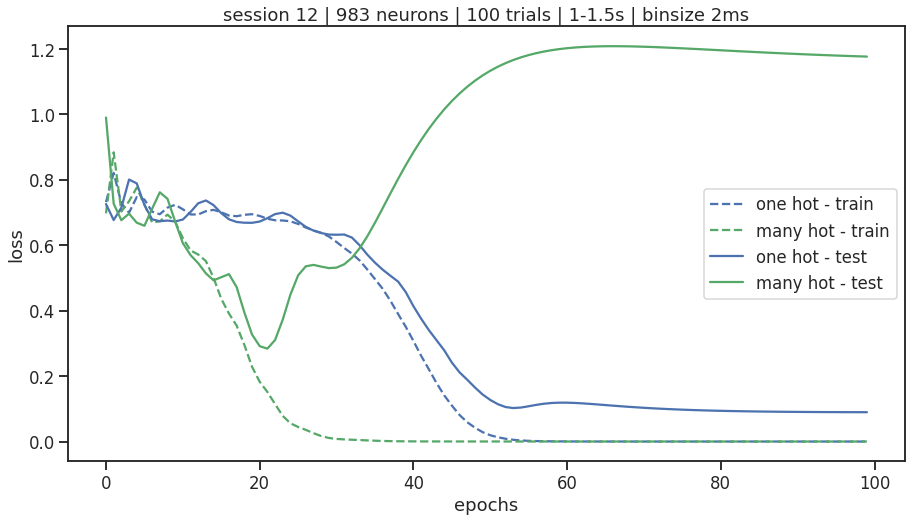

In [32]:
import seaborn as sns
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials.shape

ax.plot(np.arange(n_epochs), onehot_losses_train, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms  ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

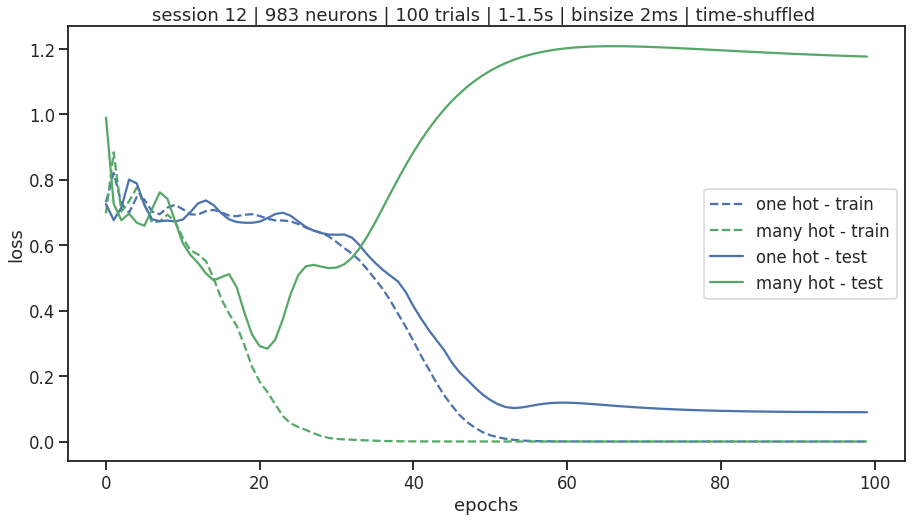

In [47]:
import seaborn as sns
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials.shape

ax.plot(np.arange(n_epochs), onehot_losses_train, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms | time-shuffled ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

In [45]:
onehot_losses_train_tc, onehot_losses_test_tc = evaluate_model(onehot_trials, labels, n_epochs=100)
manyhot_losses_train_tc, manyhot_losses_test_tc = evaluate_model(manyhot_trials, labels, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


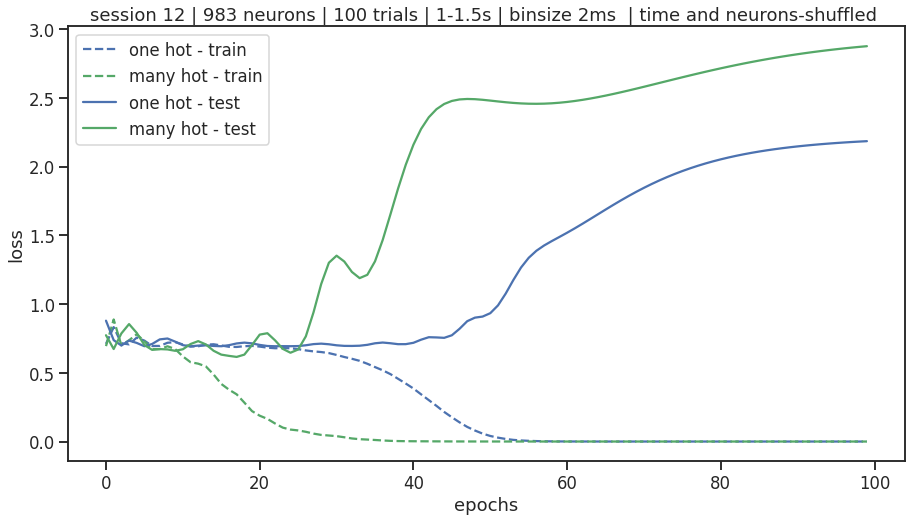

In [48]:
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials.shape

ax.plot(np.arange(n_epochs), onehot_losses_train_tc, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_tc, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_tc, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_tc, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms  | time and neurons-shuffled ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

In [ ]:
onehot_losses_train_sim, onehot_losses_test_sim = evaluate_model(onehot_trials_sim, labels_sim-1, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


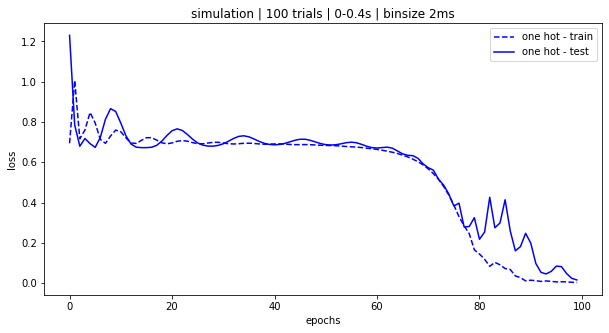

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
n_epochs = len(onehot_losses_train_sim)

ax.plot(np.arange(n_epochs), onehot_losses_train_sim, linestyle='--', color='b', label='one hot - train')
# ax.plot(np.arange(n_epochs), manyhot_losses_train, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_sim, linestyle='-', color='b', label='one hot - test')
# ax.plot(np.arange(n_epochs), manyhot_losses_test, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'simulation | {num_test_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms')
ax.legend()


In [ ]:
plt.savefig('embedding_training.png')
!gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding_training.png

In [ ]:
dir(nn_model.parameters())

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

In [ ]:
from viziphant.rasterplot import rasterplot, rasterplot_rates
session = 11
trial = 10
trial_duration = 2.5*pq.s

spiketrain_list = create_spiketrain_list(dat_ST[session]['ss'], trial, trial_duration)

fig, ax = plt.subplots(figsize=(10,10))
rasterplot_rates(spiketrain_list, ax=ax)
ax.set_ylabel(f'neurons session {session}, trial {trial}')

In [52]:
onehot_losses_train_full_tc, onehot_losses_test_full_tc = evaluate_model(onehot_trials, labels, n_epochs=100)
manyhot_losses_train_full_tc, manyhot_losses_test_full_tc = evaluate_model(manyhot_trials, labels, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


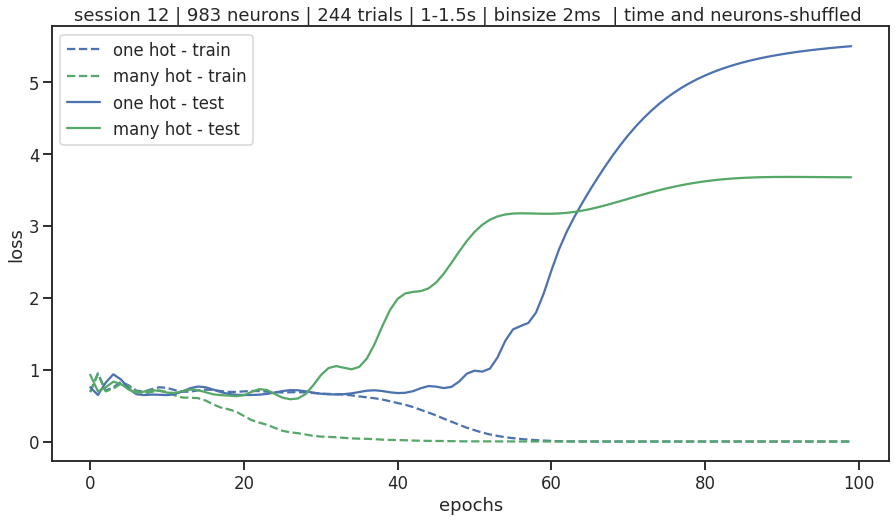

In [53]:
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials.shape

ax.plot(np.arange(n_epochs), onehot_losses_train_full_tc, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_full_tc, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_full_tc, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_full_tc, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms  | time and neurons-shuffled ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

In [63]:
onehot_losses_train_full_t, onehot_losses_test_full_t = evaluate_model(onehot_trials, labels, n_epochs=100)
manyhot_losses_train_full_t, manyhot_losses_test_full_t = evaluate_model(manyhot_trials, labels, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


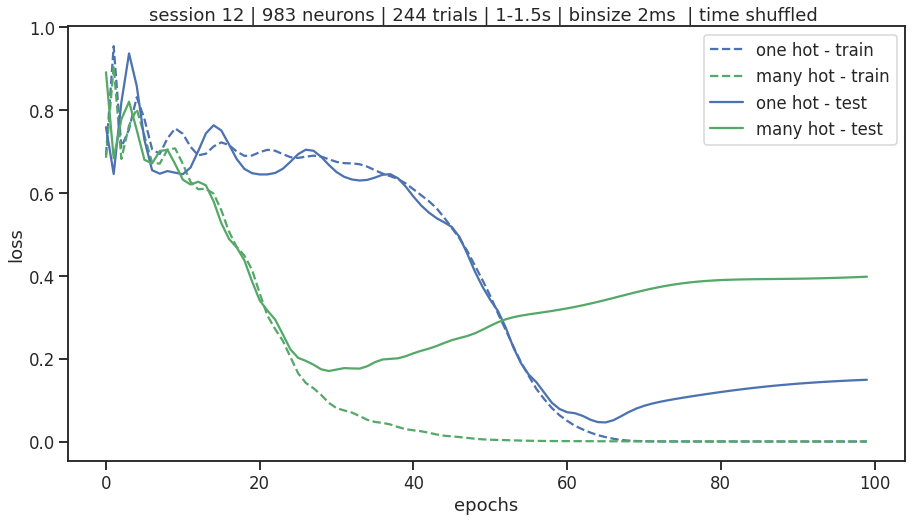

In [64]:
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials.shape

ax.plot(np.arange(n_epochs), onehot_losses_train_full_t, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_full_t, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_full_t, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_full_t, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms  | time shuffled ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

In [66]:
onehot_losses_train_s_t, onehot_losses_test_s_t = evaluate_model(onehot_trials_s, labels, n_epochs=100)
manyhot_losses_train_s_t, manyhot_losses_test_s_t = evaluate_model(manyhot_trials_s, labels, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


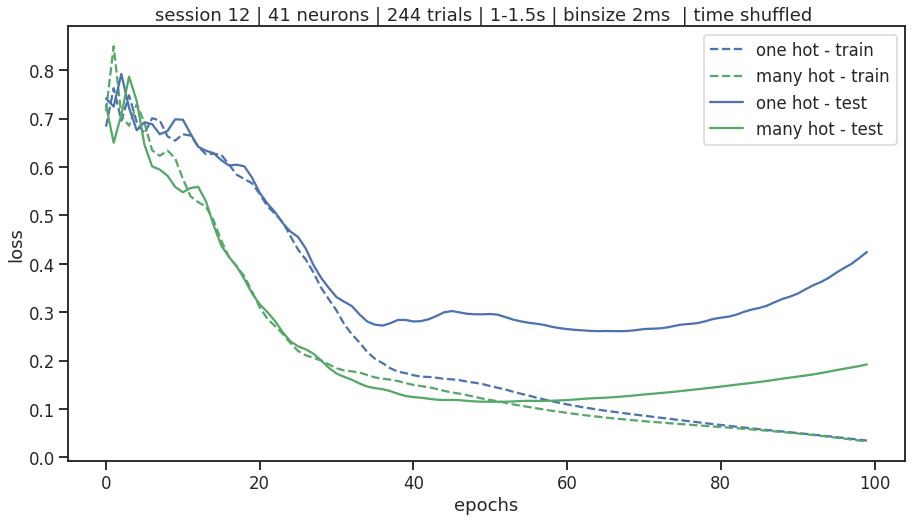

In [71]:
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials_s.shape

ax.plot(np.arange(n_epochs), onehot_losses_train_s_t, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_s_t, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_s_t, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_s_t, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms  | time shuffled ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

In [70]:
onehot_losses_train_s_tc, onehot_losses_test_s_tc = evaluate_model(onehot_trials_s, labels, n_epochs=100)
manyhot_losses_train_s_tc, manyhot_losses_test_s_tc = evaluate_model(manyhot_trials_s, labels, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


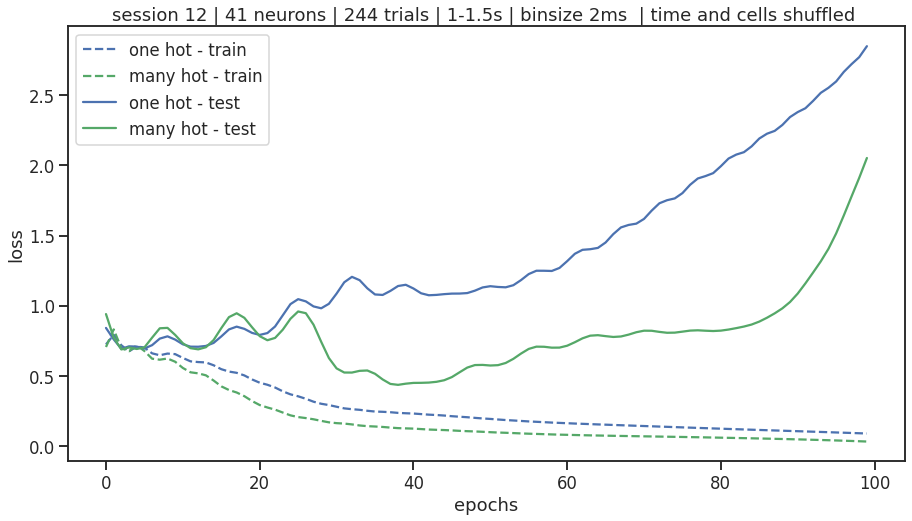

In [72]:
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials_s.shape

ax.plot(np.arange(n_epochs), onehot_losses_train_s_tc, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_s_tc, linestyle='--', color='g', label='many hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_s_tc, linestyle='-', color='b', label='one hot - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_s_tc, linestyle='-', color='g', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms  | time and cells shuffled ')
ax.legend()

# plt.savefig('embedding+gru_training.png')
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' embedding+gru_training.png

In [ ]:
import seaborn as sns
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials.shape

#ax.plot(np.arange(n_epochs), onehot_losses_train_full_t, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_train_full_t, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_full_t, linestyle='--', color='r', label='many hot - train')
##ax.plot(np.arange(100), manyhot_losses_train_s_t, linestyle='--', color='g', label='983 neurons - train')
#ax.plot(np.arange(100), manyhot_losses_train_s_t, linestyle='--', color='g', label='983 neurons - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_full_t, linestyle='-', color='b', label='one hot - test')
#ax.plot(np.arange(n_epochs), manyhot_losses_full_t, linestyle='-', color='r', label='41 neurons - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_full_t, linestyle='-', color='r', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms | time shuffled ')
ax.legend()
# {n_neurons} neurons |

# filename = f'session{session}_{num_test_trials}trials_{time_window[0]}-{time_window[1]}s_binsize{binsize}ms.png'
# plt.savefig(filename)
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' filename

In [ ]:
import seaborn as sns
sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(figsize=(15,8))

n_epochs = len(manyhot_losses_train)
n_trials, n_bins, n_neurons = manyhot_trials_s.shape

#ax.plot(np.arange(n_epochs), onehot_losses_train_full_t, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), onehot_losses_train_s_t, linestyle='--', color='b', label='one hot - train')
ax.plot(np.arange(n_epochs), manyhot_losses_train_s_t, linestyle='--', color='r', label='many hot - train')
##ax.plot(np.arange(100), manyhot_losses_train_s_t, linestyle='--', color='g', label='983 neurons - train')
#ax.plot(np.arange(100), manyhot_losses_train_s_t, linestyle='--', color='g', label='983 neurons - train')
ax.plot(np.arange(n_epochs), onehot_losses_test_s_t, linestyle='-', color='b', label='one hot - test')
#ax.plot(np.arange(n_epochs), manyhot_losses_full_t, linestyle='-', color='r', label='41 neurons - test')
ax.plot(np.arange(n_epochs), manyhot_losses_test_s_t, linestyle='-', color='r', label='many hot - test')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title(f'session {session} | {n_neurons} neurons | {n_trials} trials | {time_window[0]}-{time_window[1]}s | binsize {binsize}ms | time shuffled ')
ax.legend()
# {n_neurons} neurons |

# filename = f'session{session}_{num_test_trials}trials_{time_window[0]}-{time_window[1]}s_binsize{binsize}ms.png'
# plt.savefig(filename)
# !gupload --to '1m4YwKdWrZD0he9ZIl67DqtNR2bzH3RSo' filename